## Imports

In [8]:
%load_ext autoreload
%autoreload 2

import logging
import os

import pandas as pd
from matplotlib import pyplot as plt

import amp_research.price_movement_analysis as pma
import helpers.dbg as dbg
import helpers.env as env
import helpers.printing as pri
import helpers.s3 as hs3
import vendors.kibot.utils as kut

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
print(env.get_system_signature())

pri.config_notebook()

dbg.init_logger(verb=logging.INFO)

_LOG = logging.getLogger(__name__)

# Packages
         python: 3.7.3
         joblib: 0.14.0
          numpy: 1.17.2
         pandas: 0.25.1
        pyarrow: 0.15.0
          scipy: 1.3.1
        seaborn: 0.9.0
        sklearn: 0.21.3
    statsmodels: 0.10.1
# Last commits:
  *   7806350 saggese  Merge branch 'master' into PartTask218_PRICE_Large_price_movement_analysis (29 minutes ago) Wed Oct 16 09:28:41 2019  (HEAD -> PartTask218_PRICE_Large_price_movement_analysis, origin/PartTask218_PRICE_Large_price_movement_analysis)
  |\  
  | * c1b93f8 saggese  Wire up incremental mode and add documentation                    (  18 hours ago) Tue Oct 15 15:54:35 2019  (origin/master, origin/HEAD, master)
  | * ff51d7b saggese  Lint                                                              (  18 hours ago) Tue Oct 15 15:31:53 2019           


## Helper functions

In [10]:
SYMBOL = "CL"

In [11]:
def get_top_100(series):
    return series.sort_values(ascending=False).head(100)

# Load daily and minutely data

In [12]:
# Daily data.
s3_path = hs3.get_path()
kibot_path = os.path.join(
    s3_path, "kibot/All_Futures_Continuous_Contracts_daily/%s.csv.gz"
)
file_name = kibot_path % SYMBOL

daily_prices = kut.read_data(file_name, nrows=None)

daily_prices.tail(2)

,open,high,low,close,vol
date,,,,,
2019-07-18,56.72,57.45,54.85,55.42,764491
2019-07-19,55.84,56.49,55.12,55.76,710948


In [13]:
# Minute data.
s3_path = hs3.get_path()
kibot_path = os.path.join(
    s3_path, "kibot/All_Futures_Continuous_Contracts_1min/%s.csv.gz"
)
file_name = kibot_path % SYMBOL
minutely_prices = kut.read_data(file_name, nrows=None)

minutely_prices.tail(2)

args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/CL.csv.gz',) kwargs={'nrows': None}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/CL.csv.gz',) kwargs={'nrows': None}
Reading file_name='s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/CL.csv.gz' nrows=None


KeyboardInterrupt: 

In [ ]:
# TODO(Julia): Should we move the code to downsample in kut?
five_min_prices = minutely_prices.resample("5Min").last()

In [ ]:
five_min_prices.head()

# Daily price movements

In [23]:
tau = 18
zscored_rets = pma.get_zscored_returns(daily_prices, "daily", tau=tau)

zscored_rets = zscored_rets.abs()

top_daily_movements = get_top_100(zscored_rets)

top_daily_movements.head(10)

date
2014-12-01    3.655719
2001-11-16    3.645029
2001-09-25    3.515338
2002-03-18    3.365737
2011-05-06    3.333398
2001-09-14    3.258836
2003-07-23    3.011276
1999-10-11    2.983219
1998-12-17    2.981000
1998-01-27    2.967284
Name: ret_0, dtype: float64

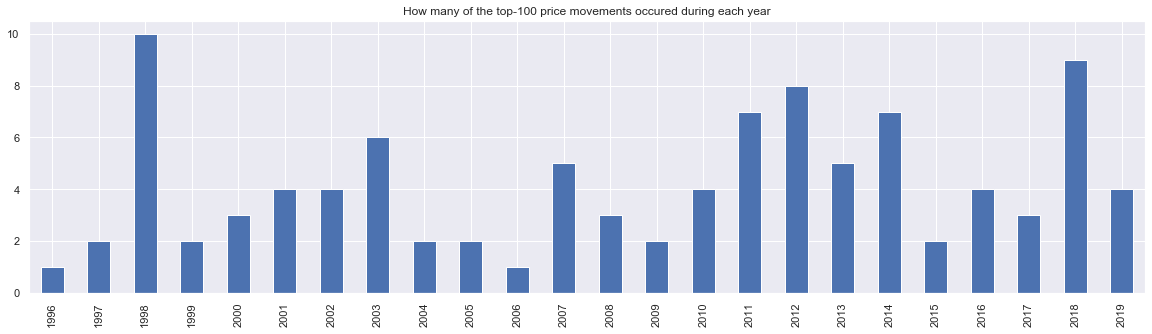

In [24]:
top_daily_movements.index.year.value_counts(sort=False).plot(kind="bar")
plt.title("How many of the top-100 price movements occured during each year")
plt.show()

In [20]:
top_daily_movements_by_year = zscored_rets.resample("Y").apply(get_top_100)
top_daily_movements_by_year.head()

date        date      
1996-12-31  1996-09-03    2.141749
            1996-10-15    1.559034
            1996-12-03    1.502157
            1996-09-12    1.434554
            1996-08-30    1.367639
Name: ret_0, dtype: float64

In [21]:
top_daily_movements_by_year.tail()

date        date      
2019-12-31  2019-02-01   -0.203385
            2019-04-16   -0.233868
            2019-05-20   -0.248263
            2019-06-18   -0.312890
            2019-06-12   -0.343229
Name: ret_0, dtype: float64

# 1-min movements

In [22]:
zscored_1min_rets = pma.get_zscored_returns(minutely_prices, "minutely")
top_1min_movements = get_top_100(zscored_1min_rets)

NameError: name 'minutely_prices' is not defined

In [ ]:
top_1min_movements.head()

In [ ]:
top_1min_movements.plot(kind="bar")
plt.title(
    f"Largest price movements in a 1 min interval (in z-score space) for the {SYMBOL} symbol"
)
plt.show()

In [ ]:
top_1min_movements_by_year = zscored_1min_rets.resample("Y").apply(get_top_100)
top_1min_movements_by_year.head()

# 5-min movements

In [ ]:
zscored_5min_rets = pma.get_zscored_returns(five_min_prices, "minutely")
top_5min_movements = get_top_100(zscored_5min_rets)

In [ ]:
top_5min_movements.head()

In [ ]:
print(
    f"Top 100 of the 5-min price movements for {SYMBOL} occur at the following time:"
)
print(pd.Series(top_5min_movements.index).dt.time.value_counts())

In [ ]:
top_5min_movements_by_year = zscored_5min_rets.resample("Y").apply(get_top_100)
top_5min_movements_by_year.head()

In [ ]:
top_5min_movements_by_year.tail()